In [0]:
# libraries

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import Pipeline

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import mlflow

import pandas as pd
from plotnine import *
from hyperopt import fmin, tpe, STATUS_OK, Trials, SparkTrials
import numpy as np
from hyperopt import hp

# deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import mlflow
import mlflow.keras
import mlflow.tensorflow
from pyspark.sql.functions import col

In [0]:
# define my own RMSE loss function for tensorflow
from tensorflow.keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

np.set_printoptions(precision=3, suppress=True)

In [0]:
# double check to make sure all columns are double type or string
deltaPath = "/delta/nb_airbnb"
clean_nb = spark.read.format("delta").load(deltaPath)
display(clean_nb.printSchema()) 

root
-- host_is_superhost: string (nullable = true)
-- host_response_time: string (nullable = true)
-- host_response_rate: double (nullable = true)
-- host_acceptance_rate: double (nullable = true)
-- host_total_listings_count: double (nullable = true)
-- neighbourhood_cleansed: string (nullable = true)
-- latitude: double (nullable = true)
-- longitude: double (nullable = true)
-- room_type: string (nullable = true)
-- accommodates: double (nullable = true)
-- bedrooms: double (nullable = true)
-- beds: double (nullable = true)
-- minimum_nights: double (nullable = true)
-- availability_30: double (nullable = true)
-- availability_60: double (nullable = true)
-- availability_90: double (nullable = true)
-- availability_365: double (nullable = true)
-- number_of_reviews: double (nullable = true)
-- review_scores_rating: double (nullable = true)
-- review_scores_accuracy: double (nullable = true)
-- review_scores_cleanliness: double (nullable = true)
-- review_scores_checkin: double (nullable = true)
-- review_scores_communication: double (nullable = true)
-- review_scores_location: double (nullable = true)
-- review_scores_value: double (nullable = true)
-- reviews_per_month: double (nullable = true)
-- price: double (nullable = true)
-- bathrooms: double (nullable = true)
-- bedrooms_na: double (nullable = true)
-- bathrooms_na: double (nullable = true)
-- beds_na: double (nullable = true)
-- review_scores_rating_na: double (nullable = true)
-- review_scores_accuracy_na: double (nullable = true)
-- review_scores_cleanliness_na: double (nullable = true)
-- review_scores_checkin_na: double (nullable = true)
-- review_scores_communication_na: double (nullable = true)
-- review_scores_location_na: double (nullable = true)
-- review_scores_value_na: double (nullable = true)

In [0]:
dropcol = ("latitude", "longitude")
final_nb = clean_nb.drop(*dropcol).na.drop().cache() # I am goign to try removing rows with null values
display(final_nb)



### I need to figure out how to deal with na's in each row!!!!

host_is_superhost,host_response_time,host_response_rate,host_acceptance_rate,host_total_listings_count,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,minimum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,bathrooms,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
f,within a few hours,1.0,1.0,1.0,Saint Andrews,Entire home/apt,6.0,2.0,5.0,2.0,5.0,16.0,40.0,315.0,21.0,4.67,4.71,4.57,5.0,4.86,4.9,4.62,0.97,242.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a day,1.0,0.33,1.0,Dundas,Entire home/apt,5.0,3.0,3.0,7.0,0.0,0.0,17.0,292.0,8.0,5.0,4.88,5.0,4.86,4.71,5.0,4.71,0.11,125.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a few hours,1.0,1.0,2.0,City of Saint John,Entire home/apt,4.0,2.0,5.0,2.0,0.0,0.0,17.0,292.0,44.0,4.59,4.68,4.77,4.68,4.84,4.68,4.73,1.27,103.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a few hours,1.0,0.67,1.0,Sackville,Private room,2.0,1.0,1.0,1.0,2.0,5.0,26.0,275.0,52.0,4.77,4.9,4.81,4.88,4.92,4.92,4.82,0.53,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
t,within an hour,1.0,0.97,3.0,Moncton,Entire home/apt,7.0,3.0,4.0,3.0,7.0,22.0,49.0,323.0,192.0,4.88,4.92,4.86,4.94,4.95,4.79,4.86,2.27,138.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a day,1.0,1.0,8.0,City of Saint John,Private room,2.0,1.0,1.0,1.0,25.0,55.0,85.0,360.0,126.0,4.58,4.63,4.83,4.65,4.67,4.67,4.64,1.71,145.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a day,1.0,1.0,0.0,Gagetown,Entire home/apt,2.0,1.0,1.0,2.0,17.0,47.0,77.0,77.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0,215.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
t,within a day,0.95,0.83,10.0,City of Saint John,Private room,2.0,1.0,1.0,1.0,0.0,0.0,0.0,80.0,39.0,4.84,4.95,4.79,4.89,4.92,4.82,4.84,0.54,125.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
t,within an hour,1.0,1.0,1.0,Bright,Entire home/apt,4.0,2.0,3.0,3.0,0.0,8.0,19.0,283.0,134.0,4.72,4.89,4.92,4.91,4.92,4.62,4.78,1.82,139.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f,within a day,1.0,1.0,8.0,City of Saint John,Private room,2.0,2.0,1.0,1.0,26.0,56.0,86.0,361.0,70.0,4.71,4.78,4.81,4.88,4.86,4.81,4.76,1.41,159.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
final_nb.count()

Out[5]: 1492

In [0]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

pandasX= final_nb.drop("price").toPandas()

X = pd.get_dummies(pandasX) # one hot encode all categorical variables

y = final_nb.select("price").toPandas()

# Split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



# Create Model and view tensorboard in notebook

In [0]:
print(len(X.columns))

162

In [0]:
def create_model():
  model = Sequential()
  model.add(Dense(20, input_dim=162, activation="relu")) #### model will not work if input_dim is wrong, the code block above will tell you what number to input 
  model.add(Dense(20, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type) Output Shape Param # 
=================================================================
dense (Dense) (None, 20) 3260 
_________________________________________________________________
dense_1 (Dense) (None, 20) 420 
_________________________________________________________________
dense_2 (Dense) (None, 1) 21 
=================================================================
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________

In [0]:
model = create_model()

model.compile(loss=root_mean_squared_error,optimizer="Adam") 

In [0]:
%sql set spark.databricks.userInfoFunctions.enabled = true; select current_user();

current_user()
tri18004@byui.edu


In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# In the following lines, replace <triv4731@vandals.uidaho.edu> with your username.
experiment_log_dir = "/dbfs/triv4731@vandals.uidaho.edu/tb"
checkpoint_path = "/dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=experiment_log_dir)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor="loss", mode="min", patience=3)

history = model.fit(X_train, y_train, validation_split=.20, epochs=35, callbacks=[tensorboard_callback, model_checkpoint, early_stopping]) 



Epoch 1/35
 1/30 [>.............................] - ETA: 42s - loss: 129.1274 3/30 [==>...........................] - ETA: 0s - loss: 135.8528 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0022s vs `on_train_batch_end` time: 0.0090s). Check your callbacks.
19/30 [==================>...........] - ETA: 0s - loss: 147.223330/30 [==============================] - 2s 30ms/step - loss: 146.1096 - val_loss: 144.0755

Epoch 00001: val_loss improved from inf to 144.07550, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt/assets
Epoch 2/35
 1/30 [>.............................] - ETA: 0s - loss: 160.883822/30 [=====================>........] - ETA: 0s - loss: 148.130230/30 [==============================] - 0s 6ms/step - loss: 144.2635 - val_loss: 141.8636

Epoch 00002: val_loss improved from 144.07550 to 141.86356, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt/assets
Epoch 3/35
 1/30 [>.............................] - ETA: 0s - loss: 119.486516/30 [===============>..............] - ETA: 0s - loss: 144.093627/30 [==========================>...] - ETA: 0s - loss: 140.919730/30 [==============================] - 0s 8ms/step - loss: 140.9649 - val_loss: 137.7823

Epoch 00003: val_loss improved from 141.86356 to 137.78230, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt/assets
Epoch 4/35
 1/30 [>.............................] - ETA: 0s - loss: 137.713917/30 [================>.............] - ETA: 0s - loss: 136.076830/30 [==============================] - 0s 6ms/step - loss: 134.8078 - val_loss: 130.4741

Epoch 00004: val_loss improved from 137.78230 to 130.47408, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt/assets
Epoch 5/35
 1/30 [>.............................] - ETA: 0s - loss: 148.016822/30 [=====================>........] - ETA: 0s - loss: 123.527330/30 [==============================] - 0s 6ms/step - loss: 124.1600 - val_loss: 118.8952

Epoch 00005: val_loss improved from 130.47408 to 118.89523, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
INFO:tensorflow:Assets written to: /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt/assets
Epoch 6/35
 1/30 [>.............................] - ETA: 0s - loss: 99.419920/30 [===================>..........] - ETA: 0s - loss: 109.348630/30 [==============================] - 0s 7ms/step - loss: 108.8585 - val_loss: 102.7351

Epoch 00006: val_loss improved from 118.89523 to 102.73506, saving model to /dbfs/triv4731@vandals.uidaho.edu/keras_checkpoint_weights.ckpt
IN

In [0]:
model.evaluate(X_test, y_test)

1/10 [==>...........................] - ETA: 0s - loss: 34.743510/10 [==============================] - 0s 2ms/step - loss: 43.3472
Out[12]: 43.347198486328125

to clear tensorboard between runs use the command: `dbutils.fs.rm(experiment_log_dir.replace("/dbfs",""), recurse=True)`

## Load TensorBoard

%md ### TensorBoard commands for Databricks Runtime 7.1 ML and below

The command in the following cell displays a link that, when clicked, opens TensorBoard in a new tab.

When you start TensorBoard this way, it continues to run until you either stop it with `dbutils.tensorboard.stop()` or you shut down the cluster.

In [0]:

%load_ext tensorboard
%tensorboard --logdir $experiment_log_dir

Launching TensorBoard...

Open in a new tab
 
 Note: TensorBoard is only available when this notebook remains attached to the cluster.

Hyperparameter tuning with hyperopt and MLflow

In [0]:
print(len(X.columns))


162

In [0]:
def create_model(n):
  model = Sequential()
  model.add(Dense(int(n["dense_l1"]), input_dim=162, activation="relu"))
  model.add(Dense(int(n["dense_l2"]), activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

### Create Hyper opt objective function

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials

def runNN(n):
  # Import tensorflow 
  import tensorflow as tf
  
  # Log run information with mlflow.tensorflow.autolog()
  mlflow.tensorflow.autolog()
  
  model = create_model(n)

  # Select optimizer
  optimizer_call = getattr(tf.keras.optimizers, n["optimizer"])
  optimizer = optimizer_call(learning_rate=n["learning_rate"])
 
  # Compile model
  model.compile(loss=root_mean_squared_error,
                optimizer=optimizer,
                metrics=[root_mean_squared_error])

  history = model.fit(X_train, y_train, validation_split=.2, epochs=10, verbose=2)

  # Evaluate the model
  score = model.evaluate(X_test, y_test, verbose=0)
  obj_metric = score[0]  
  return {"loss": obj_metric, "status": STATUS_OK}

### Define Hyperopt search space

In [0]:
space = {
  "dense_l1": hp.quniform("dense_l1", 50, 512, 1),
  "dense_l2": hp.quniform("dense_l2", 50, 512, 1),
  "learning_rate": hp.loguniform("learning_rate", -5, 0),
  "optimizer": hp.choice("optimizer", ["Adadelta", "Adam"])
 }

### Create the `SparkTrials` object

The `SparkTrials` object tells `fmin()` to distribute the tuning job across a Spark cluster. When you create the `SparkTrials` object, you can use the `parallelism` argument to set the maximum number of trials to evaluate concurently. The default setting is the number of Spark executors available.  

A higher number lets you scale-out testing of more hyperparameter settings. Because Hyperopt proposes new trials based on past results, there is a trade-off between parallelism and adaptivity. For a fixed `max_evals`, greater parallelism speeds up calculations, but lower parallelism may lead to better results since each iteration has access to more past results.

In [0]:
# If you do not specify a parallelism argument, the default is the number of available Spark executors 
spark_trials = SparkTrials(8)

### Perform hyperparameter tuning 
Put the `fmin()` call inside an MLflow run to save results to MLflow. MLflow tracks the parameters and performance metrics of each run.   

After running the following cell, you can view the results in MLflow. Click **Experiment** at the upper right to display the Experiment Runs sidebar. Click the icon at the far right next to **Experiment Runs** to display the MLflow Runs Table.

For more information about using MLflow to analyze runs, see ([AWS](https://docs.databricks.com/applications/mlflow/index.html)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/)|[GCP](https://docs.gcp.databricks.com/applications/mlflow/index.html)).

In [0]:
with mlflow.start_run():
  best_hyperparam = fmin(fn=runNN, 
                         space=space, 
                         algo=tpe.suggest, 
                         max_evals=30, 
                         trials=spark_trials)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/30 [00:00<?, ?trial/s, best loss=?] 3%|▎ | 1/30 [00:49<23:56, 49.54s/trial, best loss: 41.00745391845703] 7%|▋ | 2/30 [00:54<10:53, 23.35s/trial, best loss: 41.00745391845703] 10%|█ | 3/30 [00:56<06:07, 13.61s/trial, best loss: 41.00745391845703] 13%|█▎ | 4/30 [00:57<03:44, 8.65s/trial, best loss: 41.00745391845703] 17%|█▋ | 5/30 [01:01<02:54, 6.98s/trial, best loss: 41.00745391845703] 20%|██ | 6/30 [01:04<02:15, 5.63s/trial, best loss: 41.00745391845703] 23%|██▎ | 7/30 [01:22<03:42, 9.69s/trial, best loss: 41.00745391845703] 27%|██▋ | 8/30 [01:27<03:00, 8.20s/trial, best loss: 41.00745391845703] 30%|███ | 9/30 [01:46<04:03, 11.58s/trial, best loss: 41.00745391845703] 33%|███▎ | 10/30 [01:55<03:35, 10.80s/trial, best loss: 41.00745391845703] 40%|████ | 12/30 [02:02<02:12, 7.38s/trial, best loss: 41.00745391845703] 43%|████▎ | 13/30 [02:11<02:09, 7.59s/trial, best loss: 41.00745391845703] 47%|████▋ | 14/30 [02:15<01:46, 6.68s/trial, best loss: 41.00745391845703] 50%|█████ | 15/30 [02:33<02:27, 9.82s/trial, best loss: 41.00745391845703] 53%|█████▎ | 16/30 [02:50<02:48, 12.03s/trial, best loss: 40.292808532714844] 60%|██████ | 18/30 [02:56<01:33, 7.82s/trial, best loss: 40.292808532714844] 63%|██████▎ | 19/30 [03:03<01:24, 7.69s/trial, best loss: 40.292808532714844] 67%|██████▋ | 20/30 [03:07<01:07, 6.78s/trial, best loss: 40.292808532714844] 70%|███████ | 21/30 [03:33<01:47, 11.98s/trial, best loss: 40.292808532714844] 73%|███████▎ | 22/30 [03:36<01:16, 9.53s/trial, best loss: 40.292808532714844] 77%|███████▋ | 23/30 [03:40<00:55, 7.97s/trial, best loss: 40.292808532714844] 80%|████████ | 24/30 [03:41<00:35, 5.96s/trial, best loss: 40.292808532714844] 83%|████████▎ | 25/30 [03:53<00:38, 7.72s/trial, best loss: 40.292808532714844] 87%|████████▋ | 26/30 [04:10<00:41, 10.46s/trial, best loss: 40.292808532714844] 90%|█████████ | 27/30 [04:19<00:30, 10.03s/trial, best loss: 40.292808532714844] 93%|█████████▎| 28/30 [04:29<00:20, 10.02s/trial, best loss: 40.292808532714844] 97%|█████████▋| 29/30 [04:35<00:08, 8.83s/trial, best loss: 40.292808532714844]100%|██████████| 30/30 [04:39<00:00, 7.39s/trial, best loss: 40.292808532714844]100%|██████████| 30/30 [04:39<00:00, 9.33s/trial, best loss: 40.292808532714844]
Total Trials: 30: 30 succeeded, 0 failed, 0 cancelled.

##  Use the best set of hyperparameters to build a final model

In [0]:
import hyperopt

print(hyperopt.space_eval(space, best_hyperparam))

{'dense_l1': 288.0, 'dense_l2': 487.0, 'learning_rate': 0.010078911829296338, 'optimizer': 'Adam'}

In [0]:
first_layer = hyperopt.space_eval(space, best_hyperparam)["dense_l1"]
second_layer = hyperopt.space_eval(space, best_hyperparam)["dense_l2"]
learning_rate = hyperopt.space_eval(space, best_hyperparam)["learning_rate"]
optimizer = hyperopt.space_eval(space, best_hyperparam)["optimizer"]

In [0]:
# Get optimizer and update with learning_rate value
optimizer_call = getattr(tf.keras.optimizers, optimizer)
optimizer = optimizer_call(learning_rate=learning_rate)

In [0]:
def create_new_model():
  model = Sequential()
  model.add(Dense(first_layer, input_dim=162, activation="relu"))
  model.add(Dense(second_layer, activation="relu"))
  model.add(Dense(1, activation="linear"))
  return model

In [0]:
new_model = create_new_model()
  
new_model.compile(loss=root_mean_squared_error,
                optimizer=optimizer,
                 metrics=[root_mean_squared_error])

When `autolog()` is active, MLflow does not automatically end a run. We need to end the run that was started in Cmd 30 before starting and autologging a new run.  
For more information, see https://www.mlflow.org/docs/latest/tracking.html#automatic-logging.

In [0]:
mlflow.end_run()

Epoch 1/35
 1/38 [..............................] - ETA: 57s - loss: 155.0102 - root_mean_squared_error: 155.0102 3/38 [=>............................] - ETA: 2s - loss: 141.4888 - root_mean_squared_error: 141.4888 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0054s vs `on_train_batch_end` time: 0.0263s). Check your callbacks.
13/38 [=========>....................] - ETA: 0s - loss: 87.4146 - root_mean_squared_error: 87.4146 22/38 [================>.............] - ETA: 0s - loss: 75.3484 - root_mean_squared_error: 75.348431/38 [=======================>......] - ETA: 0s - loss: 67.3442 - root_mean_squared_error: 67.344238/38 [==============================] - 2s 10ms/step - loss: 63.6504 - root_mean_squared_error: 63.6504
Epoch 2/35
 1/38 [..............................] - ETA: 0s - loss: 36.5181 - root_mean_squared_error: 36.5181 9/38 [======>.......................] - ETA: 0s - loss: 42.6387 - root_mean_squared_error: 42.638718/38 [=============>................] - ETA: 0s - loss: 43.6979 - root_mean_squared_error: 43.697926/38 [===================>..........] - ETA: 0s - loss: 42.0623 - root_mean_squared_error: 42.062333/38 [=========================>....] - ETA: 0s - loss: 41.7733 - root_mean_squared_error: 41.773338/38 [==============================] - 0s 6ms/step - loss: 41.8162 - root_mean_squared_error: 41.8162
Epoch 3/35
 1/38 [..............................] - ETA: 0s - loss: 32.8796 - root_mean_squared_error: 32.8796 9/38 [======>.......................] - ETA: 0s - loss: 39.7563 - root_mean_squared_error: 39.756318/38 [=============>................] - ETA: 0s - loss: 41.4761 - root_mean_squared_error: 41.476127/38 [====================>.........] - ETA: 0s - loss: 40.9031 - root_mean_squared_error: 40.903137/38 [============================>.] - ETA: 0s - loss: 41.6211 - root_mean_squared_error: 41.621138/38 [==============================] - 0s 6ms/step - loss: 41.5463 - root_mean_squared_error: 41.5463
Epoch 4/35
 1/38 [..............................] - ETA: 0s - loss: 33.5532 - root_mean_squared_error: 33.553211/38 [=======>......................] - ETA: 0s - loss: 32.6992 - root_mean_squared_error: 32.699220/38 [==============>...............] - ETA: 0s - loss: 35.4529 - roo

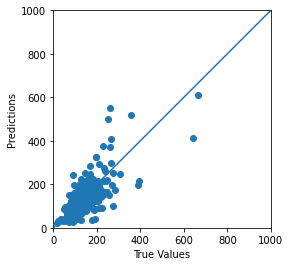

In [0]:
import matplotlib.pyplot as plt

mlflow.tensorflow.autolog()

with mlflow.start_run() as run:
  
  history = new_model.fit(X_train, y_train, epochs=35, callbacks=[early_stopping])
  
  # Save the run information to register the model later
  kerasURI = run.info.artifact_uri
  
  # Evaluate model on test dataset and log result
  mlflow.log_param("eval_result", new_model.evaluate(X_test, y_test)[0])
  
  
  # Plot predicted vs known values for a quick visual check of the model and log the plot as an artifact
  test_predictions = new_model.predict(X_test).flatten()
  a = plt.axes(aspect='equal')
  plt.scatter(test_predictions, y_test)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  lims = [0, 1000]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)
  plt.savefig("predplot.png")
  mlflow.log_artifact("predplot.png") 

In [0]:
print(new_model.evaluate(X_test, y_test))

from sklearn.metrics import r2_score
r2_score(y_test, test_predictions)


#RMSE was 41 on testing set. There still is work to do

1/10 [==>...........................] - ETA: 0s - loss: 31.7220 - root_mean_squared_error: 31.722010/10 [==============================] - 0s 2ms/step - loss: 41.2059 - root_mean_squared_error: 41.2059
[41.20586395263672, 41.20586395263672]
Out[27]: 0.671086936249212